In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

In [2]:
def act_hill(X, K, n): #Hill activator func
    return (X**n)/(K**n + X**n)

def inib_hill(X, K, n): #Hill inhibitor func
    return (K**n)/(K**n + X**n)

In [3]:
"""
Example of procedure to select which act func
to use, either act or inib Hill.
Probably want to use Hebbian Learning
or altogether just go with ELMs.
Also, ϵ can stay random, but need
a way to control the switch of ξ in each neuron.
This as a first look. Can also let it stay random
"""
W = np.random.rand(X.shape[1], 1)
ξ = np.random.choice([-1, 1], size = X.shape[0]).reshape(-1, 1)
ϵ = np.random.rand(X.shape[0]).reshape(-1, 1)
out_ = np.where(ξ == 1, act_hill(X@W, ϵ, 3), inib_hill(X@W, ϵ, 3))
corr = np.sum(y.reshape(-1, 1) == np.where(out_ > 0.5, 1, 0))/X.shape[0]
corr

0.5131810193321616

In [6]:
def in_hidden(x, W): #compute input to hidden layer output
    out_ = np.dot(x, W)
    return out_

def predict(x, W_hidden, W_out):
    out_ = in_hidden(x, W_hidden)
    y_ = np.dot(out_, W_out)
    return y_

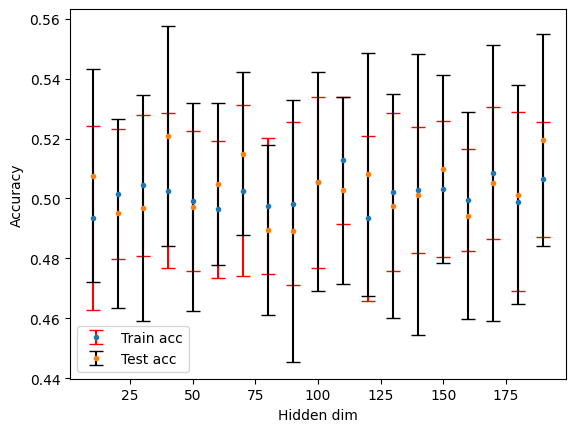

In [36]:
train_size = 0.7
in_dim = X.shape[1]
train_accs = []
test_accs = []
x_range = np.arange(10, 200, 10)
n = 3 #Hill coef

"""
This type of completely random approach seems bad.
Performance ~-> rnd
Need a way to select at each neuron for which
act func to use.
"""

for hid_dim in x_range:
    train_acc = []
    test_acc = []
    for _ in range(25): # num of sims
        rnd_idx = np.random.permutation(X.shape[0])
        train_idx = rnd_idx[:int(train_size * X.shape[0])]
        test_idx = rnd_idx[int(train_size * X.shape[0]):]
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        W = np.random.rand(in_dim, hid_dim)
        #ξ1 = np.random.choice([-1, 1], size = X_train.shape[0]).reshape(-1, 1)
        
        # Will have inib func on the outer neurons, and act func on the middle ones
        ξ1 = -np.sign(np.abs(np.arange(X_train.shape[0]) - X_train.shape[0]/2) - X_train.shape[0]/4).reshape(-1, 1) #Positional encoding
        ϵ1 = np.random.rand(X_train.shape[0]).reshape(-1, 1)
        X_ = in_hidden(X_train, W)
        X_ = np.where(ξ1 == 1, act_hill(X_, ϵ1, n), inib_hill(X_, ϵ1, n))
        #Need pseudoinvert
        β = np.dot(np.linalg.pinv(X_), y_train)
        #ξ2 = np.random.choice([-1, 1], size = X_.shape[0]).reshape(-1, 1)
        ξ2 = -np.sign(np.abs(np.arange(X_.shape[0]) - X_.shape[0]/2) - X_.shape[0]/4).reshape(-1, 1)
        ϵ2 = np.random.rand(X_.shape[0]).reshape(-1, 1)
        y_pred_train = predict(X_train, W, β).reshape(-1, 1)
        y_pred_train = np.where(ξ2 == 1, act_hill(y_pred_train, ϵ2, n), inib_hill(y_pred_train, ϵ2, n))
        y_train_cor = (np.sum(y_train.reshape(-1, 1) == np.where(y_pred_train > 0.5, 1, 0))/y_train.shape).item()
        train_acc.append(y_train_cor)

        #ξ_test = np.random.choice([-1, 1], size = X_test.shape[0]).reshape(-1, 1)
        ξ_test = -np.sign(np.abs(np.arange(X_test.shape[0]) - X_test.shape[0]/2) - X_test.shape[0]/4).reshape(-1, 1)
        ϵ_test = np.random.rand(X_test.shape[0]).reshape(-1, 1)
        y_pred_test = predict(X_test, W, β).reshape(-1, 1)
        y_pred_test = np.where(ξ_test == 1, act_hill(y_pred_test, ϵ_test, n), inib_hill(y_pred_test, ϵ_test, n))
        y_test_cor = (np.sum(y_test.reshape(-1, 1) == np.where(y_pred_test > 0.5, 1, 0))/y_test.shape).item()
        test_acc.append(y_test_cor)

    train_accs.append((np.mean(train_acc), np.std(train_acc)))
    test_accs.append((np.mean(test_acc), np.std(test_acc)))

train_μ, train_σ = zip(*train_accs)
test_μ, test_σ = zip(*test_accs)

plt.errorbar(x_range, train_μ, yerr=train_σ, fmt=".", capsize=5, capthick=1, ecolor="r", label="Train acc")
plt.errorbar(x_range, test_μ, yerr=test_σ, fmt=".", capsize=5, capthick=1, ecolor="k", label="Test acc")
plt.xlabel("Hidden dim")
plt.ylabel("Accuracy")
plt.legend()